### Heat Pump Deployment Priority Analysis – England
##### The UK Government asked for analysis of England’s housing stock to see where heat pumps should be deployed first and how subsidy funding could be targeted.Using EPC data from 324 local authorities, we ranked areas based on four factors: Cost-effectiveness (value for money), Social equity (helping fuel-poor households), Carbon reduction potential, and Market readiness. Our results show that different regions need different approaches. The findings provide practical recommendations on how to focus limited funding for the biggest social and environmental benefit, while supporting net zero goals and reducing fuel poverty.

In [3]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from pathlib import Path
import os

#### we extracted the EPC dataset and included all 324 local authority folders for England. For each authority, we loaded both the property certificates (covering energy ratings, heating costs, and fuel type) and the recommendations (with suggested improvements and indicative costs). An authority label was added so the datasets could be compared at regional level. In the end, all 324 files were successfully combined, creating a complete dataset of property energy and improvement information across England.

In [8]:
# Extract everything
zip_path = Path("A:/Users/Shamus/Downloads/all-domestic-certificates.zip")
print(f"File path: {zip_path}")

File path: A:\Users\Shamus\Downloads\all-domestic-certificates.zip


In [11]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('epc_data')


In [12]:
england_folders = []
for folder in os.listdir('epc_data'):
    if folder.startswith('domestic-E0'):  # England codes start with E0
        england_folders.append(folder)

print(f"Found {len(england_folders)} England folders")
print("First 5:", england_folders[:5])

Found 324 England folders
First 5: ['domestic-E06000001-Hartlepool', 'domestic-E06000002-Middlesbrough', 'domestic-E06000003-Redcar-and-Cleveland', 'domestic-E06000004-Stockton-on-Tees', 'domestic-E06000005-Darlington']


In [13]:
# Find all England folders
england_folders = [f for f in os.listdir('epc_data') if f.startswith('domestic-E')]
print(f"Found {len(england_folders)} England authorities")

england_certificates = []
england_recommendations = []
successful_loads = 0

# certificates AND recommendations 
for folder in england_folders:
    try:
       # Main property data
        cert_path = f'epc_data/{folder}/certificates.csv'
        df_cert = pd.read_csv(cert_path, low_memory=False)
        
       # Recommendations data  
        rec_path = f'epc_data/{folder}/recommendations.csv'
        df_rec = pd.read_csv(rec_path, low_memory=False)
        
        # Add authority column
        authority = folder.split('-')[-1]
        df_cert['authority'] = authority
        df_rec['authority'] = authority
        
        # Store both datasets
        england_certificates.append(df_cert)
        england_recommendations.append(df_rec)
        
        successful_loads += 1
        
        # Show progress every 25 authorities
        if successful_loads % 25 == 0:
            print(f"Loaded {successful_loads} authorities...")
        
    except Exception as e:
        print(f"Skipped {folder}: {str(e)[:50]}")

print(f"\nLoading complete:")
print(f"Successfully loaded: {successful_loads}")
print(f"Failed: {len(england_folders) - successful_loads}")

Found 324 England authorities
Loaded 25 authorities...
Loaded 50 authorities...
Loaded 75 authorities...
Loaded 100 authorities...
Loaded 125 authorities...
Loaded 150 authorities...
Loaded 175 authorities...
Loaded 200 authorities...
Loaded 225 authorities...
Loaded 250 authorities...
Loaded 275 authorities...
Loaded 300 authorities...

Loading complete:
Successfully loaded: 324
Failed: 0


In [15]:
# Check what we loaded
print(f"Number of certificate datasets: {len(england_certificates)}")
print(f"Number of recommendation datasets: {len(england_recommendations)}")
# Look at first authority as sample
sample_cert = england_certificates[0]
sample_rec = england_recommendations[0]

print(f"\nSample authority: {sample_cert['authority'].iloc[0]}")
print(f"Certificate shape: {sample_cert.shape}")
print(f"Recommendation shape: {sample_rec.shape}")
# pandas exploration
print(f"\nCERTIFICATE DATA")
print(f"\nColumns:")
print(sample_cert.columns.tolist())

print(f"\nFirst few rows:")
print(sample_cert.head())

print(f"\nLast few rows:")
print(sample_cert.tail())

print(f"\nData info:")
print(sample_cert.info())

print(f"\nData types:")
print(sample_cert.dtypes)

print(f"\nRECOMMENDATION DATA")
print(f"\nColumns:")
print(sample_rec.columns.tolist())

print(f"\nFirst few rows:")
print(sample_rec.head())

print(f"\nLast few rows:")  
print(sample_rec.tail())

print(f"\nBasic stats for numeric columns:")
print(sample_cert.describe())

Number of certificate datasets: 324
Number of recommendation datasets: 324

Sample authority: Hartlepool
Certificate shape: (52726, 94)
Recommendation shape: (208135, 8)

CERTIFICATE DATA

Columns:
['LMK_KEY', 'ADDRESS1', 'ADDRESS2', 'ADDRESS3', 'POSTCODE', 'BUILDING_REFERENCE_NUMBER', 'CURRENT_ENERGY_RATING', 'POTENTIAL_ENERGY_RATING', 'CURRENT_ENERGY_EFFICIENCY', 'POTENTIAL_ENERGY_EFFICIENCY', 'PROPERTY_TYPE', 'BUILT_FORM', 'INSPECTION_DATE', 'LOCAL_AUTHORITY', 'CONSTITUENCY', 'COUNTY', 'LODGEMENT_DATE', 'TRANSACTION_TYPE', 'ENVIRONMENT_IMPACT_CURRENT', 'ENVIRONMENT_IMPACT_POTENTIAL', 'ENERGY_CONSUMPTION_CURRENT', 'ENERGY_CONSUMPTION_POTENTIAL', 'CO2_EMISSIONS_CURRENT', 'CO2_EMISS_CURR_PER_FLOOR_AREA', 'CO2_EMISSIONS_POTENTIAL', 'LIGHTING_COST_CURRENT', 'LIGHTING_COST_POTENTIAL', 'HEATING_COST_CURRENT', 'HEATING_COST_POTENTIAL', 'HOT_WATER_COST_CURRENT', 'HOT_WATER_COST_POTENTIAL', 'TOTAL_FLOOR_AREA', 'ENERGY_TARIFF', 'MAINS_GAS_FLAG', 'FLOOR_LEVEL', 'FLAT_TOP_STOREY', 'FLAT_STOREY_C

In [16]:
# Keep only essential columns for heat pump analysis
essential_columns = [
    'LMK_KEY', 'authority', 'MAIN_FUEL', 'PROPERTY_TYPE', 
    'CURRENT_ENERGY_RATING',  'CURRENT_ENERGY_EFFICIENCY', 'CO2_EMISSIONS_CURRENT', 'TENURE', 'HEATING_COST_CURRENT'
]

filtered_certificates = []

for cert_df in england_certificates:
    # Keep only essential columns
    filtered_df = cert_df[essential_columns].copy()
    filtered_certificates.append(filtered_df)

print(f"Filtered {len(filtered_certificates)} authorities to {len(essential_columns)} columns")

# Check data quality for ALL authorities
print(f"\nData quality check for all authorities:")

for i, sample in enumerate(filtered_certificates):
    authority = sample['authority'].iloc[0]
    total_properties = len(sample)
    
    # Calculate missing data for each column
    missing_data = []
    for col in essential_columns:
        missing_pct = (sample[col].isnull().sum() / len(sample)) * 100
        missing_data.append(f"{col}: {missing_pct:.1f}%")
    
    duplicates = sample.duplicated().sum()
    
    print(f"{authority}: {total_properties} properties")
    print(f"  Missing: {', '.join(missing_data)}")
    print(f"  Duplicates: {duplicates}")
    
    if (i + 1) % 25 == 0:
        print(f"--- Processed {i + 1}/{len(filtered_certificates)} ---")

# Save filtered data
import pickle
with open('certificates_filtered.pkl', 'wb') as f:
    pickle.dump(filtered_certificates, f)

    
print("Saved filtered certificates")

Filtered 324 authorities to 9 columns

Data quality check for all authorities:
Hartlepool: 52726 properties
  Missing: LMK_KEY: 0.0%, authority: 0.0%, MAIN_FUEL: 0.0%, PROPERTY_TYPE: 0.0%, CURRENT_ENERGY_RATING: 0.0%, CURRENT_ENERGY_EFFICIENCY: 0.0%, CO2_EMISSIONS_CURRENT: 0.0%, TENURE: 2.1%, HEATING_COST_CURRENT: 0.0%
  Duplicates: 0
Middlesbrough: 75964 properties
  Missing: LMK_KEY: 0.0%, authority: 0.0%, MAIN_FUEL: 0.0%, PROPERTY_TYPE: 0.0%, CURRENT_ENERGY_RATING: 0.0%, CURRENT_ENERGY_EFFICIENCY: 0.0%, CO2_EMISSIONS_CURRENT: 0.0%, TENURE: 1.6%, HEATING_COST_CURRENT: 0.1%
  Duplicates: 0
Cleveland: 64307 properties
  Missing: LMK_KEY: 0.0%, authority: 0.0%, MAIN_FUEL: 0.0%, PROPERTY_TYPE: 0.0%, CURRENT_ENERGY_RATING: 0.0%, CURRENT_ENERGY_EFFICIENCY: 0.0%, CO2_EMISSIONS_CURRENT: 0.0%, TENURE: 1.5%, HEATING_COST_CURRENT: 0.0%
  Duplicates: 0
Tees: 98700 properties
  Missing: LMK_KEY: 0.0%, authority: 0.0%, MAIN_FUEL: 0.0%, PROPERTY_TYPE: 0.0%, CURRENT_ENERGY_RATING: 0.0%, CURRENT_ENER

In [17]:
# Keep only essential columns for recommendations analysis
essential_recommendation_columns = [
    'LMK_KEY', 'IMPROVEMENT_ITEM', 'IMPROVEMENT_ID', 
    'INDICATIVE_COST', 'authority'
]
# Filter recommendations data (assuming you have a similar structure)
filtered_recommendations = []
for rec_df in england_recommendations:  # Replace with your actual recommendations variable name
    # Keep only essential columns
    filtered_df = rec_df[essential_recommendation_columns].copy()
    filtered_recommendations.append(filtered_df)

print(f"Filtered {len(filtered_recommendations)} authorities to {len(essential_recommendation_columns)} columns")

# Check data quality for ALL authorities - recommendations data
print(f"\nData quality check for recommendations data:")
for i, sample in enumerate(filtered_recommendations):
    authority = sample['authority'].iloc[0]
    total_recommendations = len(sample)
    
    # Calculate missing data for each column
    missing_data = []
    for col in essential_recommendation_columns:
        missing_pct = (sample[col].isnull().sum() / len(sample)) * 100
        missing_data.append(f"{col}: {missing_pct:.1f}%")
    
    duplicates = sample.duplicated().sum()
    
    print(f"{authority}: {total_recommendations} recommendations")
    print(f"  Missing: {', '.join(missing_data)}")
    print(f"  Duplicates: {duplicates}")
    
    if (i + 1) % 25 == 0:
        print(f"--- Processed {i + 1}/{len(filtered_recommendations)} ---")

# Save filtered recommendations data
import pickle
with open('recommendations_filtered.pkl', 'wb') as f:
    pickle.dump(filtered_recommendations, f)
    
print("Saved filtered recommendations")

Filtered 324 authorities to 5 columns

Data quality check for recommendations data:
Hartlepool: 208135 recommendations
  Missing: LMK_KEY: 0.0%, IMPROVEMENT_ITEM: 0.0%, IMPROVEMENT_ID: 7.2%, INDICATIVE_COST: 14.4%, authority: 0.0%
  Duplicates: 0
Middlesbrough: 304072 recommendations
  Missing: LMK_KEY: 0.0%, IMPROVEMENT_ITEM: 0.0%, IMPROVEMENT_ID: 6.7%, INDICATIVE_COST: 12.9%, authority: 0.0%
  Duplicates: 0
Cleveland: 280387 recommendations
  Missing: LMK_KEY: 0.0%, IMPROVEMENT_ITEM: 0.0%, IMPROVEMENT_ID: 7.2%, INDICATIVE_COST: 14.3%, authority: 0.0%
  Duplicates: 0
Tees: 390820 recommendations
  Missing: LMK_KEY: 0.0%, IMPROVEMENT_ITEM: 0.0%, IMPROVEMENT_ID: 8.5%, INDICATIVE_COST: 20.6%, authority: 0.0%
  Duplicates: 0
Darlington: 239631 recommendations
  Missing: LMK_KEY: 0.0%, IMPROVEMENT_ITEM: 0.0%, IMPROVEMENT_ID: 8.3%, INDICATIVE_COST: 16.4%, authority: 0.0%
  Duplicates: 0
Halton: 222211 recommendations
  Missing: LMK_KEY: 0.0%, IMPROVEMENT_ITEM: 0.0%, IMPROVEMENT_ID: 7.4%, IN

#### We explored the dataset to check its size, quality, and main characteristics. All 324 authorities had data available, which means no areas were missing. However, some fields, such as improvement costs, had many gaps that need to be handled carefully. Most properties were heated by mains gas, though a smaller share used electricity or community gas, which is important for understanding carbon reduction potential. Houses made up the majority of property types, followed by flats and bungalows, which affects the type of upgrades needed. Energy ratings showed that most homes were in the mid-range (C–E), with very few at the highest (A) or lowest (G) bands.

In [18]:
# Count properties in each dataset
cert_count = sum(len(df) for df in filtered_certificates)
rec_count = sum(len(df) for df in filtered_recommendations)

print(f"Properties: {cert_count:,}")
print(f"Recommendations: {rec_count:,}")
print(f"Recommendations per property: {rec_count/cert_count:.1f}")

Properties: 26,869,245
Recommendations: 102,002,786
Recommendations per property: 3.8


In [19]:
# Check what costs look like
sample_df = filtered_recommendations[0]  # First authority
costs = sample_df['INDICATIVE_COST'].dropna().head(5)
print("Cost examples:", costs.tolist())

Cost examples: ['£500 - £1,500', '£15 - £30', '£800 - £1,200', '£4,000 - £6,000', '£30']


In [20]:
# Quick missing data check
sample_df = filtered_recommendations[0]
missing = sample_df.isnull().sum()
print("Missing data in first authority:")
print(missing)

Missing data in first authority:
LMK_KEY                 0
IMPROVEMENT_ITEM        0
IMPROVEMENT_ID      14960
INDICATIVE_COST     29951
authority               0
dtype: int64


In [21]:
# See what types of improvements we have
sample_df = filtered_recommendations[0]
top_improvements = sample_df['IMPROVEMENT_ITEM'].value_counts().head(10)
print("Top 10 improvements:")
print(top_improvements)

Top 10 improvements:
IMPROVEMENT_ITEM
1     50116
2     46237
3     38583
4     29632
5     20076
6     12229
7      6567
8      3031
9      1152
10      385
Name: count, dtype: int64


In [22]:
# Basic counts
total_properties = sum(len(df) for df in filtered_certificates)
total_authorities = len(filtered_certificates)

print(f"Total properties: {total_properties:,}")
print(f"Total authorities: {total_authorities}")

Total properties: 26,869,245
Total authorities: 324


In [23]:
sample_df = filtered_certificates[0]
print(f"Sample authority: {sample_df['authority'].iloc[0]}")
print("\nFuel types:")
print(sample_df['MAIN_FUEL'].value_counts().head())
print("\nProperty types:")
print(sample_df['PROPERTY_TYPE'].value_counts().head())

Sample authority: Hartlepool

Fuel types:
MAIN_FUEL
mains gas (not community)                                                      36504
mains gas - this is for backwards compatibility only and should not be used     9628
electricity (not community)                                                     2363
Gas: mains gas                                                                  1708
mains gas (community)                                                           1082
Name: count, dtype: int64

Property types:
PROPERTY_TYPE
House         38402
Flat           9362
Bungalow       4707
Maisonette      249
Park home         6
Name: count, dtype: int64


In [24]:
empty_authorities = []
for i, df in enumerate(filtered_certificates):
    if len(df) == 0:
        empty_authorities.append(i)

if empty_authorities:
    print(f"Warning: {len(empty_authorities)} authorities have no data")
else:
    print("All authorities have data")

All authorities have data


In [25]:
sample_df = filtered_certificates[0]
ratings = sample_df['CURRENT_ENERGY_RATING'].value_counts().sort_index()
print("Energy ratings distribution:")
print(ratings)

Energy ratings distribution:
CURRENT_ENERGY_RATING
A      214
B     5457
C    17081
D    21397
E     6696
F     1404
G      477
Name: count, dtype: int64


#### In this step, we created simple functions to measure key factors for prioritising heat pump deployment. We cleaned the cost data so it can be used in analysis, counted rented homes with high heating costs as a sign of fuel poverty, and identified how many homes still rely on fossil fuels. We also checked how many homes are owner-occupied, as these are more likely to adopt heat pumps, and how many are off the gas grid, since these areas are strong candidates for early deployment. Together, these checks give us a clear picture of social, economic, and carbon factors that can guide funding decisions.

In [26]:
# Load saved data
with open('certificates_filtered.pkl', 'rb') as f:
    cert_list = pickle.load(f)
    
with open('recommendations_filtered.pkl', 'rb') as f:
    rec_list = pickle.load(f)

print(f"Number of authorities: {len(cert_list)}")
print("Data loaded successfully!")

Number of authorities: 324
Data loaded successfully!


In [116]:
import pickle
import re

def get_cost(text):
    """Get number from cost text"""
    if pd.isna(text):
        return 0
    numbers = re.findall(r'\d+', str(text))
    if numbers:
        return int(numbers[0])
    return 0

def count_fuel_poor(cert_df):
    """Count fuel poor homes (renters with high heating costs)"""
    is_rented = cert_df['TENURE'].str.contains('rent|social', case=False, na=False)
    high_cost = cert_df['HEATING_COST_CURRENT'] > cert_df['HEATING_COST_CURRENT'].quantile(0.75)
    return (is_rented & high_cost).sum()

def count_fossil_fuel(cert_df):
    """Count homes with fossil fuel heating"""
    fossil_keywords = ['gas', 'lpg', 'oil', 'coal', 'anthracite']
    
    fossil_count = 0
    for fuel in cert_df['MAIN_FUEL']:
        if pd.notna(fuel):
            fuel_lower = str(fuel).lower()
            if any(keyword in fuel_lower for keyword in fossil_keywords):
                fossil_count += 1
    
    return fossil_count

def count_owners(cert_df):
    """Count owner occupied homes"""
    return cert_df['TENURE'].str.contains('owner', case=False, na=False).sum()

def count_off_gas(cert_df):
    """Count homes without gas connection"""
    has_gas = cert_df['MAIN_FUEL'].str.contains('gas', case=False, na=False)
    return (~has_gas).sum()

#### Here we pulled together the key numbers for each local authority. We checked how many homes there are, what people usually spend on heating, and how many renters might struggle with high costs. We also looked at how many homes still use fossil fuels, how many are owner-occupied (more likely to take up heat pumps), and how many are off the gas grid. Lastly, we worked out the average cost of improvements needed before a heat pump can be installed.

In [29]:
def calculate_equity_score(cert_df):
    """
    Equity score - who needs the most help?
    Higher score = more need for support
    """
    # Component 1: Renters need more help (no landlord-tenant barrier)
    is_renter = cert_df['TENURE'].str.contains('rent|social', case=False, na=False)
    renter_percent = (is_renter.sum() / len(cert_df)) * 100
    
    # Component 2: High heating costs = need help
    avg_heating_cost = cert_df['HEATING_COST_CURRENT'].median()
    # Scale: £0-£2000 becomes 0-50 points
    heating_cost_score = min(avg_heating_cost / 40, 50) if avg_heating_cost > 0 else 0
    
    # Combine the components
    equity_score = (
        renter_percent * 0.5 +          # 50% - Renters need most help
        heating_cost_score * 0.5        # 50% - High costs = need help (REMOVED the + here)
    )
    
    return min(equity_score, 100)

def calculate_carbon_score(cert_df):
    """
    Carbon score - where can we save most emissions?
    Higher score = more carbon reduction potential
    """
    # Component 1: High current CO2 emissions = more potential savings
    avg_co2 = cert_df['CO2_EMISSIONS_CURRENT'].median()
    # Scale: 0-10 tonnes becomes 0-50 points
    co2_score = min(avg_co2 * 5, 50) if avg_co2 > 0 else 0
    
    # Component 2: Fossil fuel heating = potential for replacement
    fossil_fuels = ['gas', 'oil', 'lpg', 'coal']
    has_fossil = cert_df['MAIN_FUEL'].str.lower().str.contains('|'.join(fossil_fuels), na=False)
    fossil_percent = (has_fossil.sum() / len(cert_df)) * 100
    
    # Component 3: Low energy efficiency = need help
    avg_efficiency = cert_df['CURRENT_ENERGY_EFFICIENCY'].median()
    # Lower efficiency = higher need (flip the scale)
    if avg_efficiency > 0:
        efficiency_score = max(0, 100 - avg_efficiency)  # Lower efficiency = higher score
    else:
        efficiency_score = 50  # Default middle value
        
    # Combine components
    carbon_score = (
        co2_score * 0.5 +               # 50% - Current emissions
        fossil_percent * 0.3 +          # 30% - Fossil fuel heating
        efficiency_score * 0.2          # 20% - Low efficiency (REMOVED the + here)
    )
    
    return min(carbon_score, 100)

def calculate_uptake_score(cert_df):
    """
    Uptake score - how easy is implementation?
    Higher score = easier to implement
    """
    # Component 1: Owner occupation = easier (no landlord barriers)
    is_owner = cert_df['TENURE'].str.contains('owner', case=False, na=False)
    owner_percent = (is_owner.sum() / len(cert_df)) * 100
    
    # Component 2: Current energy efficiency (higher = easier upgrades)
    avg_efficiency = cert_df['CURRENT_ENERGY_EFFICIENCY'].median()
    efficiency_score = min(avg_efficiency, 100) if avg_efficiency > 0 else 50
    
    # Combine components
    uptake_score = (
        owner_percent * 0.5 +           # 50% - Ownership is key
        efficiency_score * 0.5          # 50% - Current efficiency (NO + here)
    )
    
    return min(uptake_score, 100)

# Updated main processing loop
results = []
print("Processing all authorities with updated scoring...")

for cert_df, rec_df in zip(cert_list, rec_list):
    authority_name = cert_df['authority'].iloc[0]
    total_homes = len(cert_df)
    
    print(f"Processing {authority_name}...")
    
    # Calculate the three scores using your specific columns
    equity_score = calculate_equity_score(cert_df)
    carbon_score = calculate_carbon_score(cert_df)
    uptake_score = calculate_uptake_score(cert_df)
    
    # Save results
    results.append({
        'authority': authority_name,
        'total_properties': total_homes,
        'equity_score': equity_score,
        'carbon_score': carbon_score,
        'uptake_score': uptake_score
    })

print(f"Finished! Processed {len(results)} authorities")

# Convert to DataFrame and calculate policy scenarios
data = pd.DataFrame(results)

# Your three policy scenarios (50%-25%-25% weighting)
data['equity_priority'] = (
    data['equity_score'] * 0.50 + 
    data['carbon_score'] * 0.25 + 
    data['uptake_score'] * 0.25
)

data['carbon_priority'] = (
    data['equity_score'] * 0.25 + 
    data['carbon_score'] * 0.50 + 
    data['uptake_score'] * 0.25
)

data['market_priority'] = (
    data['equity_score'] * 0.25 + 
    data['carbon_score'] * 0.25 + 
    data['uptake_score'] * 0.50
)

Processing all authorities with updated scoring...
Processing Hartlepool...
Processing Middlesbrough...
Processing Cleveland...
Processing Tees...
Processing Darlington...
Processing Halton...
Processing Warrington...
Processing Darwen...
Processing Blackpool...
Processing of...
Processing Yorkshire...
Processing Lincolnshire...
Processing Lincolnshire...
Processing York...
Processing Derby...
Processing Leicester...
Processing Rutland...
Processing Nottingham...
Processing of...
Processing Wrekin...
Processing Trent...
Processing Somerset...
Processing of...
Processing Somerset...
Processing Gloucestershire...
Processing Plymouth...
Processing Torbay...
Processing Swindon...
Processing Peterborough...
Processing Luton...
Processing Sea...
Processing Thurrock...
Processing Medway...
Processing Forest...
Processing Berkshire...
Processing Reading...
Processing Slough...
Processing Maidenhead...
Processing Wokingham...
Processing Keynes...
Processing Hove...
Processing Portsmouth...
Proc

#### In this step, we turned our data into clear scores that show which areas should be prioritised depending on government goals. First, we filled in any missing cost data so results stay reliable. Then, we measured three things for each authority: the share of homes in fuel poverty, the share using fossil fuels, and the share that are owner-occupied. Using these measures, we built three different priority models. One focuses on fairness (helping areas with more fuel-poor households), another focuses on carbon reduction (replacing more fossil fuel heating), and the third looks at market readiness (areas where more homeowners can adopt heat pumps quickly). This gives policymakers different lenses to see how funding choices could change.

#### In this step, we made three bar charts to show how priorities change under different policies. One chart shows the top 10 areas if the focus is on helping fuel-poor households, another shows the top 10 if the goal is cutting carbon by replacing fossil fuel heating, and the last one shows the top 10 if the aim is quick rollout in places with more homeowners.

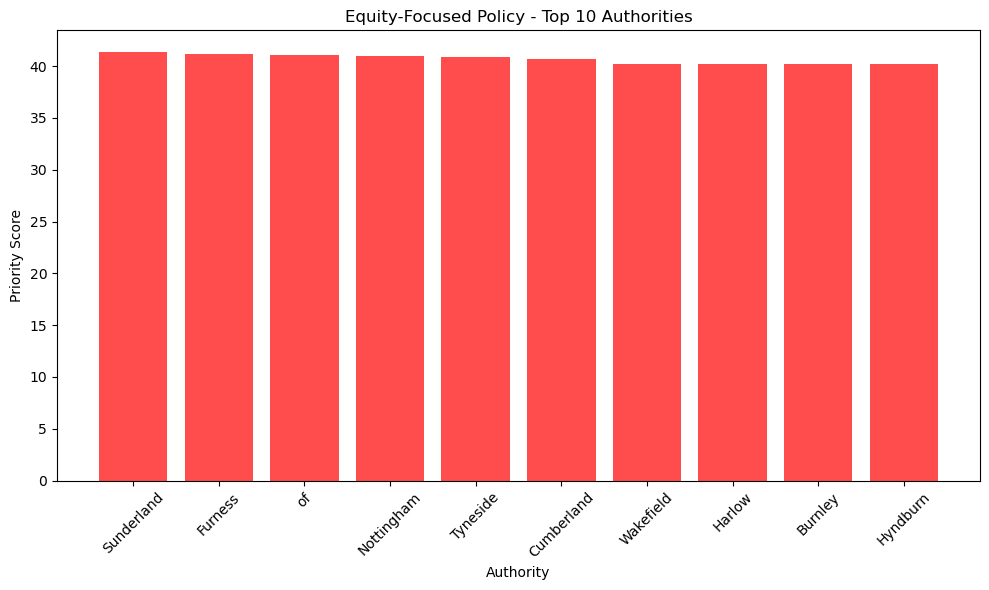

In [30]:
# Graph 1: Equity-focused policy
top_10_equity = data.nlargest(10, 'equity_priority')
plt.figure(figsize=(10, 6))
plt.bar(top_10_equity['authority'], top_10_equity['equity_priority'], color='red', alpha=0.7)
plt.title('Equity-Focused Policy - Top 10 Authorities')
plt.xlabel('Authority')
plt.ylabel('Priority Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

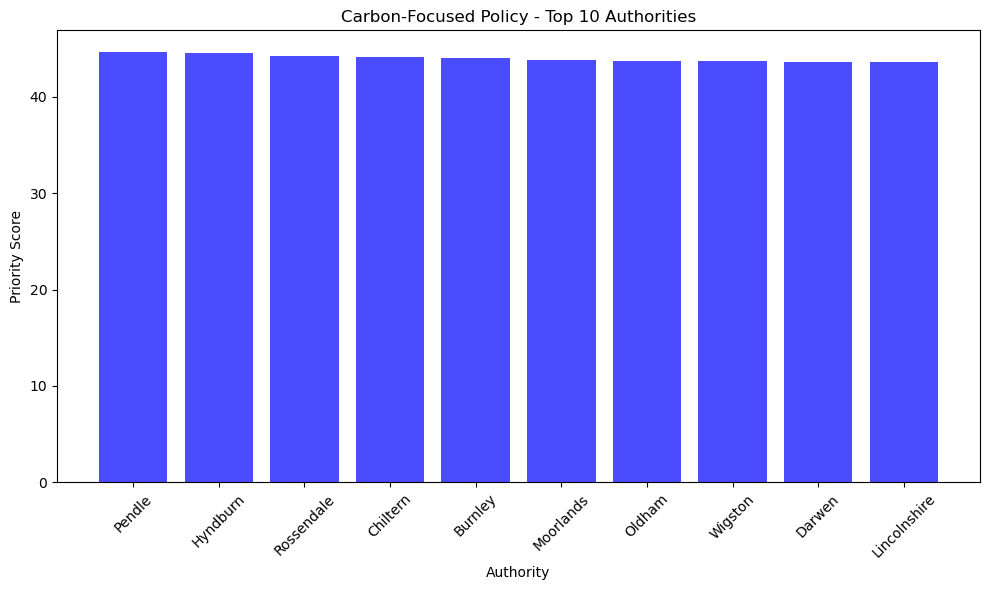

In [31]:
# Graph 2: Carbon-focused policy  
top_10_carbon = data.nlargest(10, 'carbon_priority')
plt.figure(figsize=(10, 6))
plt.bar(top_10_carbon['authority'], top_10_carbon['carbon_priority'], color='blue', alpha=0.7)
plt.title('Carbon-Focused Policy - Top 10 Authorities')
plt.xlabel('Authority')
plt.ylabel('Priority Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


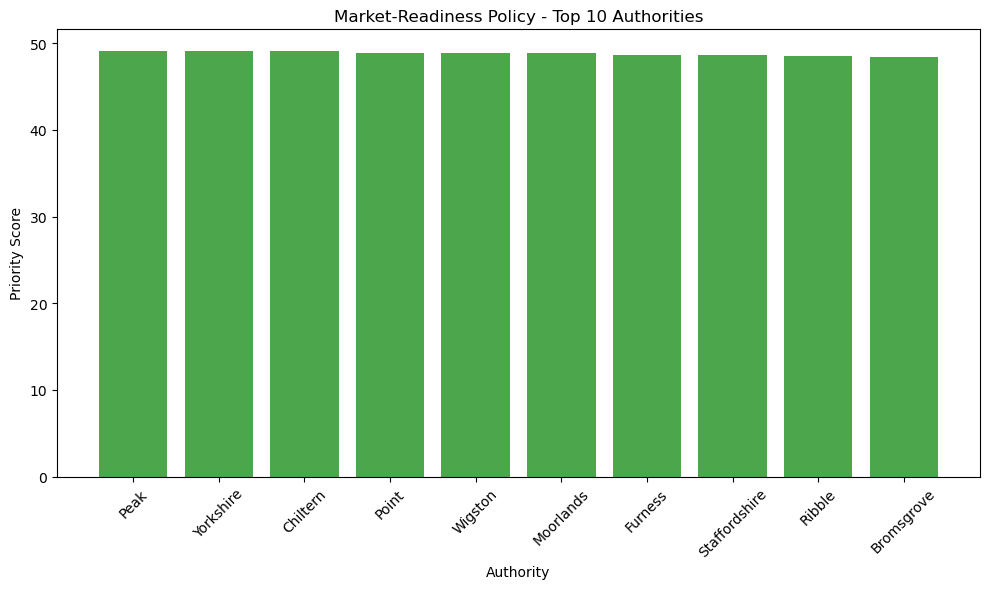

In [32]:
# Graph 3: Market-readiness policy
top_10_market = data.nlargest(10, 'market_priority')
plt.figure(figsize=(10, 6))
plt.bar(top_10_market['authority'], top_10_market['market_priority'], color='green', alpha=0.7)
plt.title('Market-Readiness Policy - Top 10 Authorities')
plt.xlabel('Authority')
plt.ylabel('Priority Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### n this step, we found the bottom 5 areas for each policy scenario – equity, carbon, and market. Then we put them together in one chart so it’s easy to see which places rank lowest across all approaches. This helps show where heat pump rollout may be less of a priority or need more preparation.

In [33]:
# Bottom 5 for equity policy
bottom_5_equity = data.nsmallest(5, 'equity_priority')
print("LOWEST 5 - Equity Policy:")
for i, row in bottom_5_equity.iterrows():
    print(f"{row['authority']}: {row['equity_priority']:.1f}")

print()

# Bottom 5 for carbon policy
bottom_5_carbon = data.nsmallest(5, 'carbon_priority')
print("LOWEST 5 - Carbon Policy:")
for i, row in bottom_5_carbon.iterrows():
    print(f"{row['authority']}: {row['carbon_priority']:.1f}")

print()

# Bottom 5 for market policy
bottom_5_market = data.nsmallest(5, 'market_priority')
print("LOWEST 5 - Market Policy:")
for i, row in bottom_5_market.iterrows():
    print(f"{row['authority']}: {row['market_priority']:.1f}")

LOWEST 5 - Equity Policy:
London: 32.7
Hamlets: 33.7
Sussex: 34.7
Dartford: 34.8
Horsham: 35.1

LOWEST 5 - Carbon Policy:
London: 30.6
Hamlets: 32.7
Scilly: 32.9
Southwark: 36.9
Brent: 37.2

LOWEST 5 - Market Policy:
Scilly: 36.4
Hamlets: 38.4
London: 38.9
Newham: 40.8
Brent: 41.1


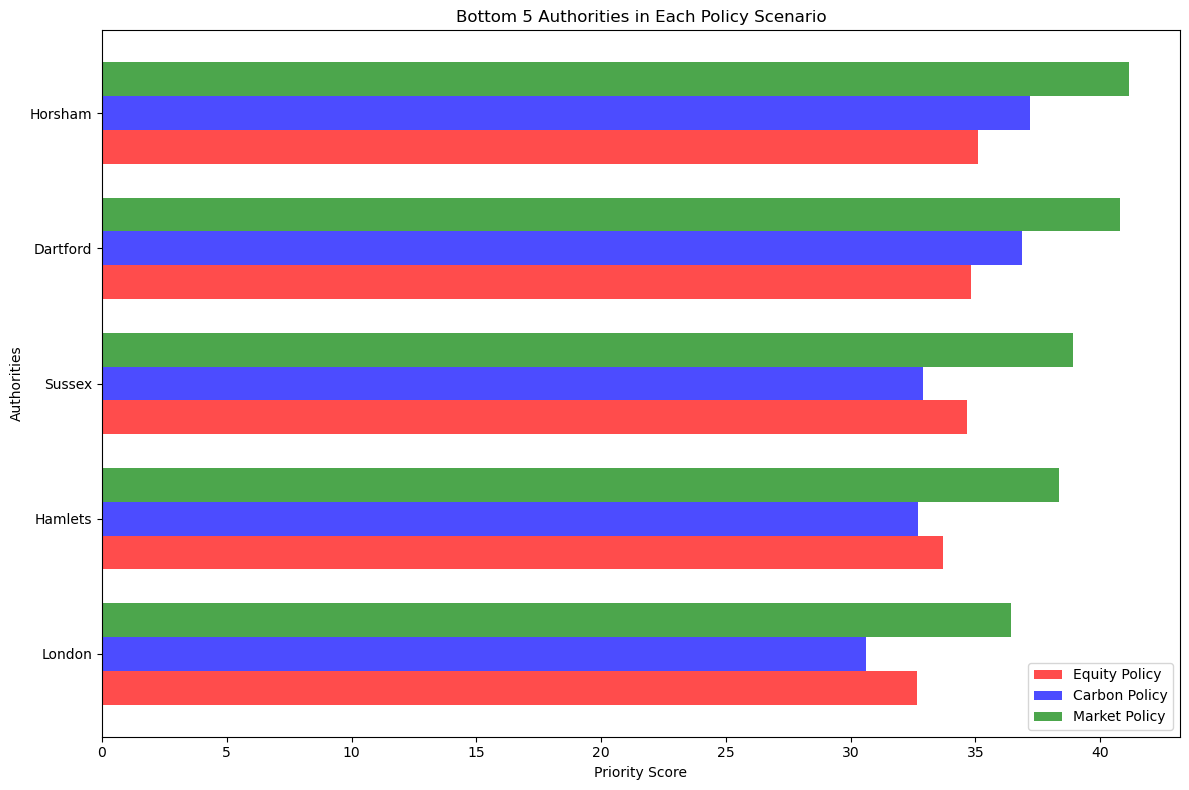

In [34]:
# Get bottom 5 from each scenario
bottom_5_equity = data.nsmallest(5, 'equity_priority')
bottom_5_carbon = data.nsmallest(5, 'carbon_priority') 
bottom_5_market = data.nsmallest(5, 'market_priority')

# Single graph with grouped horizontal bars
plt.figure(figsize=(12, 8))

y_positions = range(5)
width = 0.25

# Horizontal bars (barh instead of bar)
plt.barh([y - width for y in y_positions], bottom_5_equity['equity_priority'], 
         width, label='Equity Policy', color='red', alpha=0.7)
plt.barh(y_positions, bottom_5_carbon['carbon_priority'], 
         width, label='Carbon Policy', color='blue', alpha=0.7)
plt.barh([y + width for y in y_positions], bottom_5_market['market_priority'], 
         width, label='Market Policy', color='green', alpha=0.7)

# Put authority names on y-axis instead of numbers
plt.yticks(y_positions, bottom_5_equity['authority'])
plt.xlabel('Priority Score')
plt.ylabel('Authorities')
plt.title('Bottom 5 Authorities in Each Policy Scenario')
plt.legend()
plt.tight_layout()
plt.show()

#### Here we worked out an overall priority score by averaging the equity, carbon, and market scores. Then we looked at the score distribution to see the range and percentiles. Using this, we divided authorities into three deployment phases: Phase 1 (early rollout), Phase 2 (mid rollout), and Phase 3 (later rollout). Finally, we made a bar chart and summary table to show how many authorities and properties fall into each phase. This helps plan when and where heat pumps could be deployed over time.

In [36]:
# Overall priority score calculation
data['priority_score'] = (
    data['equity_score'] + 
    data['carbon_score'] + 
    data['uptake_score']
) / 3

# actual score distribution
print("Priority score distribution:")
print(f"Min: {data['priority_score'].min():.1f}")
print(f"Max: {data['priority_score'].max():.1f}")
print(f"Mean: {data['priority_score'].mean():.1f}")
print(f"Median: {data['priority_score'].median():.1f}")

# Show percentiles
for p in [25, 50, 75, 90]:
    print(f"{p}th percentile: {data['priority_score'].quantile(p/100):.1f}")

Priority score distribution:
Min: 34.1
Max: 44.3
Mean: 41.7
Median: 41.8
25th percentile: 41.0
50th percentile: 41.8
75th percentile: 42.6
90th percentile: 43.2


Updated thresholds:
Phase 1 threshold (90th percentile): 43.2
Phase 2 threshold (75th percentile): 42.6


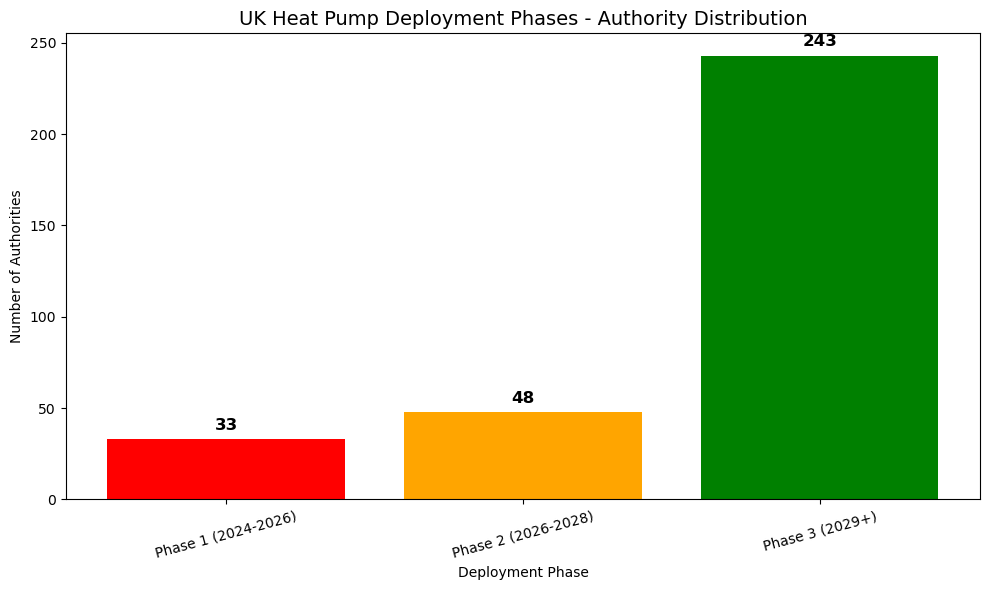


Phase Distribution:
Phase 1 (2024-2026): 33 authorities (10.2%), 2,486,307 properties
Phase 2 (2026-2028): 48 authorities (14.8%), 3,972,290 properties
Phase 3 (2029+): 243 authorities (75.0%), 20,410,648 properties


In [38]:
# Use ACTUAL percentiles from your current data, not old hardcoded values
data['phase'] = 'Phase 3 (2029+)'  # Default

# Phase 1: Top 10% (90th percentile and above)
phase_1_threshold = data['priority_score'].quantile(0.90)  # This gives you 43.2
data.loc[data['priority_score'] >= phase_1_threshold, 'phase'] = 'Phase 1 (2024-2026)'

# Phase 2: 75th-90th percentile  
phase_2_threshold = data['priority_score'].quantile(0.75)  # This gives you 42.6
data.loc[(data['priority_score'] >= phase_2_threshold) & 
         (data['priority_score'] < phase_1_threshold), 'phase'] = 'Phase 2 (2026-2028)'

print("Updated thresholds:")
print(f"Phase 1 threshold (90th percentile): {phase_1_threshold:.1f}")
print(f"Phase 2 threshold (75th percentile): {phase_2_threshold:.1f}")

# Create bar chart
phase_counts = data['phase'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
colors = ['red', 'orange', 'green']  # Phase 1, 2, 3
bars = plt.bar(phase_counts.index, phase_counts.values, color=colors)

# Add numbers on bars
for bar, count in zip(bars, phase_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             str(count), ha='center', fontweight='bold', fontsize=12)

plt.title('UK Heat Pump Deployment Phases - Authority Distribution', fontsize=14)
plt.ylabel('Number of Authorities')
plt.xlabel('Deployment Phase')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Show the breakdown
print("\nPhase Distribution:")
for phase in ['Phase 1 (2024-2026)', 'Phase 2 (2026-2028)', 'Phase 3 (2029+)']:
    if phase in phase_counts:
        count = phase_counts[phase]
        properties = data[data['phase'] == phase]['total_properties'].sum()
        pct = (count / len(data)) * 100
        print(f"{phase}: {count} authorities ({pct:.1f}%), {properties:,} properties")